In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Elon_musk.csv to Elon_musk.csv


In [4]:
tweets = pd.read_csv("Elon_musk.csv",encoding='cp1252')
tweets

Unnamed: 0                                               Text
0              1                             @kunalb11 I’m an alien
1              2  @ID_AA_Carmack Ray tracing on Cyberpunk with H...
2              3                @joerogan @Spotify Great interview!
3              4                    @gtera27 Doge is underestimated
4              5  @teslacn Congratulations Tesla China for amazi...
...          ...                                                ...
1994        1995  @flcnhvy True, it sounds so surreal, but the n...
1995        1996  @PPathole Make sure to read ur terms &amp; con...
1996        1997                @TeslaGong @PPathole Samwise Gamgee
1997        1998  @PPathole Altho Dumb and Dumber is <U+0001F525...
1998        1999                          Progress update August 28

[1999 rows x 2 columns]

In [5]:
# drop Unnamed: 0 column
tweets.drop(["Unnamed: 0"],inplace = True, axis =1)
tweets

Text
0                                @kunalb11 I’m an alien
1     @ID_AA_Carmack Ray tracing on Cyberpunk with H...
2                   @joerogan @Spotify Great interview!
3                       @gtera27 Doge is underestimated
4     @teslacn Congratulations Tesla China for amazi...
...                                                 ...
1994  @flcnhvy True, it sounds so surreal, but the n...
1995  @PPathole Make sure to read ur terms &amp; con...
1996                @TeslaGong @PPathole Samwise Gamgee
1997  @PPathole Altho Dumb and Dumber is <U+0001F525...
1998                          Progress update August 28

[1999 rows x 1 columns]

## Data Exploration

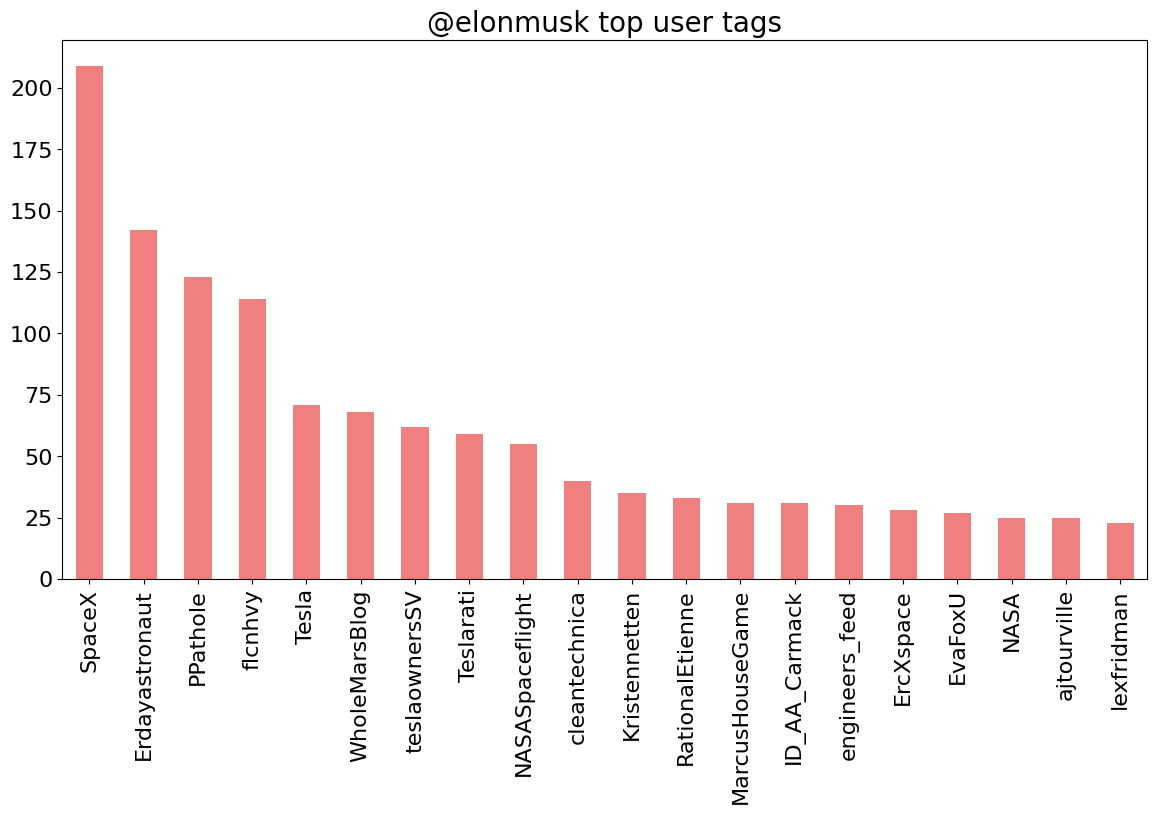

In [9]:
import itertools

c = list(itertools.chain(*tweets.Text.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                                                     if '@' in handle.replace(":", "")]).tolist()))

pd.Series(c).value_counts().head(20).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, fontsize=16)
pass

## Preprocessing

In [10]:
# Cleaning the text by removing removing irrelevant information
import re # Regular expression
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    return text

clean = lambda x: clean_text(x)

tweets["Text"] = tweets["Text"].apply(clean_text) # Clean The Text
tweets.head(11)

Text
0                                         im an alien
1   idaacarmack ray tracing on cyberpunk with hdr ...
2                    joerogan spotify great interview
3                              doge is underestimated
4   teslacn congratulations tesla china for amazin...
5                           happy new year of the ox 
6   frodo was the underdoge\nall thought he would ...
7                    owensparks flcnhvy  haha thanks 
8   flcnhvy  indeed tweets definitely do not repre...
9    the most entertaining outcome is the most likely
10                        givedirectly just sent some

In [12]:
# Word frequency
freq = pd.Series(" ".join(tweets["Text"]).split()).value_counts()[:40] # for top 40
freq

the               487
to                400
a                 356
is                355
of                315
spacex            239
in                219
amp               218
for               194
tesla             166
will              165
be                157
erdayastronaut    142
this              140
it                138
we                136
on                129
that              128
rt                127
but               126
ppathole          123
i                 117
flcnhvy           114
with              108
are               100
at                 93
you                91
yes                86
and                84
not                77
great              76
was                74
have               74
teslaownerssv      73
as                 73
from               72
its                69
wholemarsblog      68
so                 67
just               64
dtype: int64

In [14]:
# Removing Stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words("english")
tweets["Text"] = tweets["Text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Word frequency after removal of stopwords
freq_sw = pd.Series(" ".join(tweets["Text"]).split()).value_counts()[:20] # for top 20
freq_sw

spacex             239
amp                218
tesla              166
erdayastronaut     142
rt                 127
ppathole           123
flcnhvy            114
yes                 86
great               76
teslaownerssv       73
wholemarsblog       68
teslarati           59
nasaspaceflight     55
haha                55
good                51
launch              49
sure                43
yeah                41
cleantechnica       40
would               40
dtype: int64

## Feature extaction

In [20]:
# count vectorizer tells the frequency of a word
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(min_df = 1, max_df = 2)
X = vectorizer.fit_transform(tweets["Text"])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_df.head(20)

term  occurrences  frequency
0           aber            1   0.000241
1            abo            1   0.000241
2         aboard            1   0.000241
3          abort            3   0.000723
4        absence            1   0.000241
5       absolute            1   0.000241
6         absorb            1   0.000241
7     absorption            1   0.000241
8         absurd            2   0.000482
9       absurdly            1   0.000241
10            ac            1   0.000241
11      academia            1   0.000241
12         accel            1   0.000241
13      accelera            1   0.000241
14    accelerate            1   0.000241
15   accelerated            1   0.000241
16  accelerating            1   0.000241
17  acceleration            1   0.000241
18   accelerator            1   0.000241
19        accept            1   0.000241

In [21]:
# TFIDF - Term frequency inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, max_df = 0.5, smooth_idf=True) #keep top 1000 words
doc_vec = vectorizer.fit_transform(tweets["Text"])
names_features = vectorizer.get_feature_names_out()
dense = doc_vec.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns = names_features)
df

able  abort  absolutely  access  accurate  actual  actually  adamklotz  \
0      0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
1      0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
2      0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
3      0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
4      0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
...    ...    ...         ...     ...       ...     ...       ...        ...   
1994   0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
1995   0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
1996   0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
1997   0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   
1998   0.0    0.0         0.0     0.0       0.0     0.0       0.0        0.0   

      add  adding  ...  yeah      year  years  yes  yesterdays  youre  \
0     0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
1     0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
2     0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
3     0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
4     0.0     0.0  ...   0.0  0.356742    0.0  0.0         0.0    0.0   
...   ...     ...  ...   ...       ...    ...  ...         ...    ...   
1994  0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
1995  0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
1996  0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
1997  0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   
1998  0.0     0.0  ...   0.0  0.000000    0.0  0.0         0.0    0.0   

      yourfavgas  yup  zero  zone  
0            0.0  0.0   0.0   0.0  
1            0.0  0.0   0.0   0.0  
2            0.0  0.0   0.0   0.0  
3            0.0  0.0   0.0   0.0  
4            0.0  0.0   0.0   0.0  
...          ...  ...   ...   ...  
1994         0.0  0.0   0.0   0.0  
1995         0.0  0.0   0.0   0.0  
1996         0.0  0.0   0.0   0.0  
1997         0.0  0.0   0.0   0.0  
1998         0.0  0.0   0.0   0.0  

[1999 rows x 1000 columns]

N-Gram

In [22]:
#Bi-gram
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                reverse=True)
    return words_freq[:n]

In [24]:
top2_words = get_top_n2_words(tweets["Text"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df.head(50)

Bi-gram  Freq
0                        rt spacex    71
1                    spacex falcon    17
2            erdayastronaut spacex    16
3                      pretty much    12
4                          rt nasa    12
5                     waemd spacex    11
6                      giga berlin    10
7                      first stage    10
8          teslaratiteam teslarati    10
9                      nasa spacex     9
10                    falcon first     9
11          erdayastronaut flcnhvy     9
12                   flcnhvy tesla     8
13                     coming soon     8
14                   spacex dragon     8
15                     static fire     8
16                     crew dragon     8
17           thesheetztweetz waemd     8
18          astrobehnken astrodoug     8
19                       next year     7
20                   falcon launch     7
21                      great game     7
22                      next month     7
23               wholemarsblog yes     7
24                    course still     7
25                      still love     7
26                       next week     7
27  tobyliiiiiiiiii erdayastronaut     7
28                         one day     7
29                        rt tesla     7
30                ercxspace spacex     7
31             erdayastronaut yeah     7
32    marcushousegame felixschlang     7
33               first operational     7
34                 teslarati tesla     7
35        ppathole thesheetztweetz     7
36           spacex spacexstarlink     7
37  erdayastronaut nasaspaceflight     7
38                     spacex nasa     6
39                    stage landed     6
40                  spacex liftoff     6
41                      good point     6
42    nasaspaceflight bocachicagal     6
43  nasaspaceflight erdayastronaut     6
44         ppathole erdayastronaut     6
45                      body flaps     6
46       ercxspace marcushousegame     6
47  spacexstarlink wanationalguard     6
48            soumiksf idaacarmack     6
49          tlowdon ethicalskeptic     6

[Text(0, 0, 'rt spacex'),
 Text(1, 0, 'spacex falcon'),
 Text(2, 0, 'erdayastronaut spacex'),
 Text(3, 0, 'pretty much'),
 Text(4, 0, 'rt nasa'),
 Text(5, 0, 'waemd spacex'),
 Text(6, 0, 'giga berlin'),
 Text(7, 0, 'first stage'),
 Text(8, 0, 'teslaratiteam teslarati'),
 Text(9, 0, 'nasa spacex'),
 Text(10, 0, 'falcon first'),
 Text(11, 0, 'erdayastronaut flcnhvy'),
 Text(12, 0, 'flcnhvy tesla'),
 Text(13, 0, 'coming soon'),
 Text(14, 0, 'spacex dragon'),
 Text(15, 0, 'static fire'),
 Text(16, 0, 'crew dragon'),
 Text(17, 0, 'thesheetztweetz waemd'),
 Text(18, 0, 'astrobehnken astrodoug'),
 Text(19, 0, 'next year')]

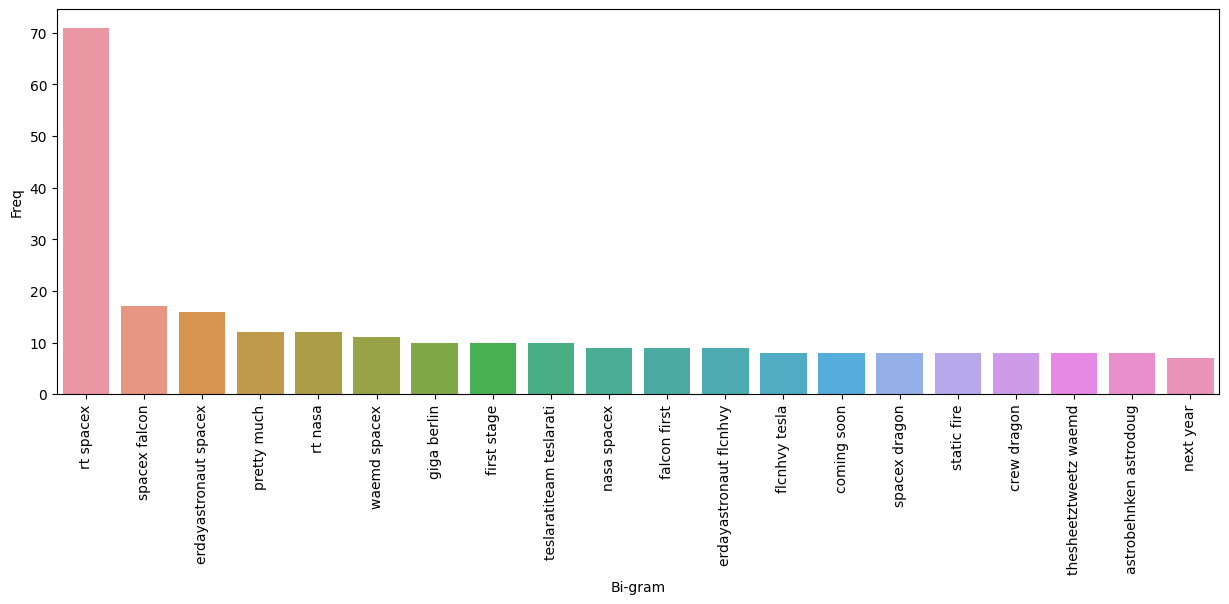

In [27]:
#Bi-gram plot
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (15, 5))
plot=sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_bigram["Bi-gram"])

In [28]:
#Tri-gram
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                reverse=True)
    return words_freq[:n]

In [29]:
top3_words = get_top_n3_words(tweets["Text"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
top3_df

Tri-gram  Freq
0                              rt spacex falcon    17
1                            falcon first stage     9
2                           spacex falcon first     8
3                  thesheetztweetz waemd spacex     8
4                             course still love     7
..                                          ...   ...
195                          flaps amp nosecone     2
196              erdayastronaut ppathole spacex     2
197  spceenthusiast tjmurphymit thesheetztweetz     2
198       marcushousegame spacex erdayastronaut     2
199            spacex erdayastronaut elonsworld     2

[200 rows x 2 columns]

[Text(0, 0, 'rt spacex falcon'),
 Text(1, 0, 'falcon first stage'),
 Text(2, 0, 'spacex falcon first'),
 Text(3, 0, 'thesheetztweetz waemd spacex'),
 Text(4, 0, 'course still love'),
 Text(5, 0, 'ppathole thesheetztweetz waemd'),
 Text(6, 0, 'waemd spacex spacexstarlink'),
 Text(7, 0, 'first stage landed'),
 Text(8, 0, 'rt spacex liftoff'),
 Text(9, 0, 'spacex spacexstarlink wanationalguard'),
 Text(10, 0, 'spacex felixschlang marcushousegame'),
 Text(11, 0, 'still love droneship'),
 Text(12, 0, 'rt spacex dragon'),
 Text(13, 0, 'first operational mission'),
 Text(14, 0, 'casparstanley ercxspace marcushousegame'),
 Text(15, 0, 'ercxspace marcushousegame felixschlang'),
 Text(16, 0, 'erdayastronaut joshbickett ajtourville'),
 Text(17, 0, 'joshbickett ajtourville spacex'),
 Text(18, 0, 'spacex falcon launches'),
 Text(19, 0, 'tjcooney lrocket spacex')]

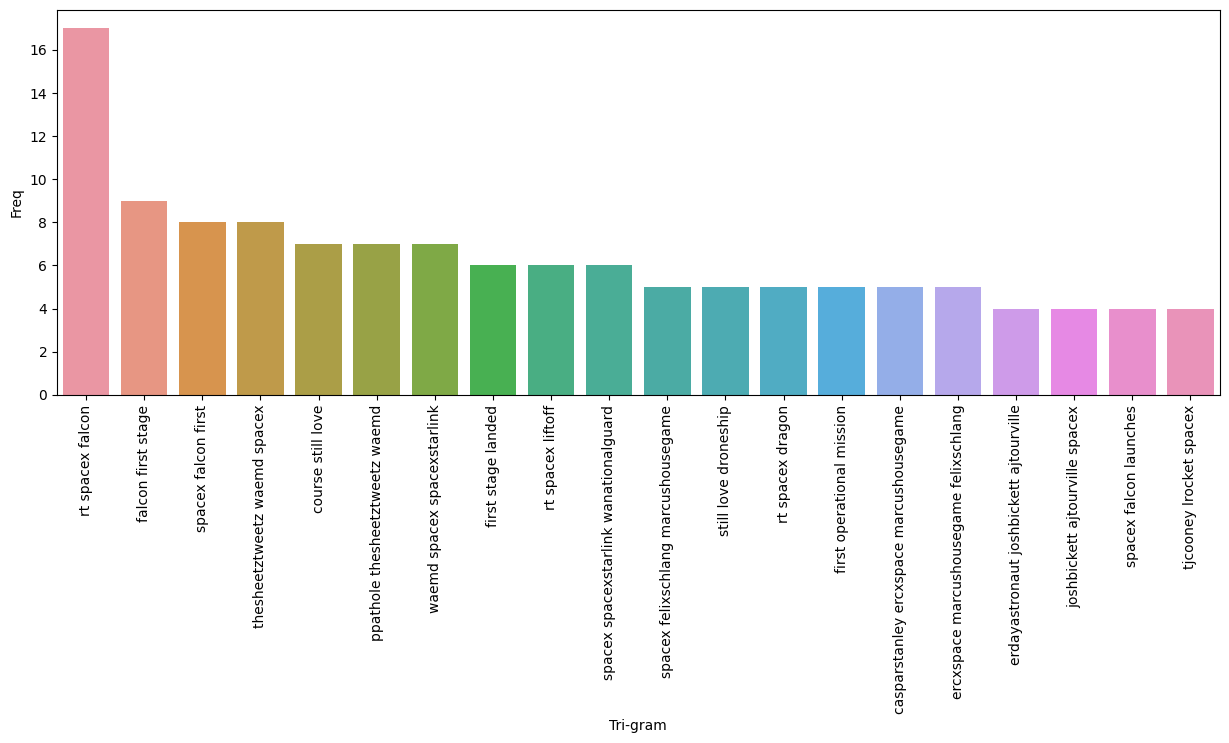

In [30]:
#Tri-gram plot
import seaborn as sns
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (15, 5))
plot=sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_trigram["Tri-gram"])

# Creating Wordcloud

In [32]:
string_Total = " ".join(tweets["Text"])

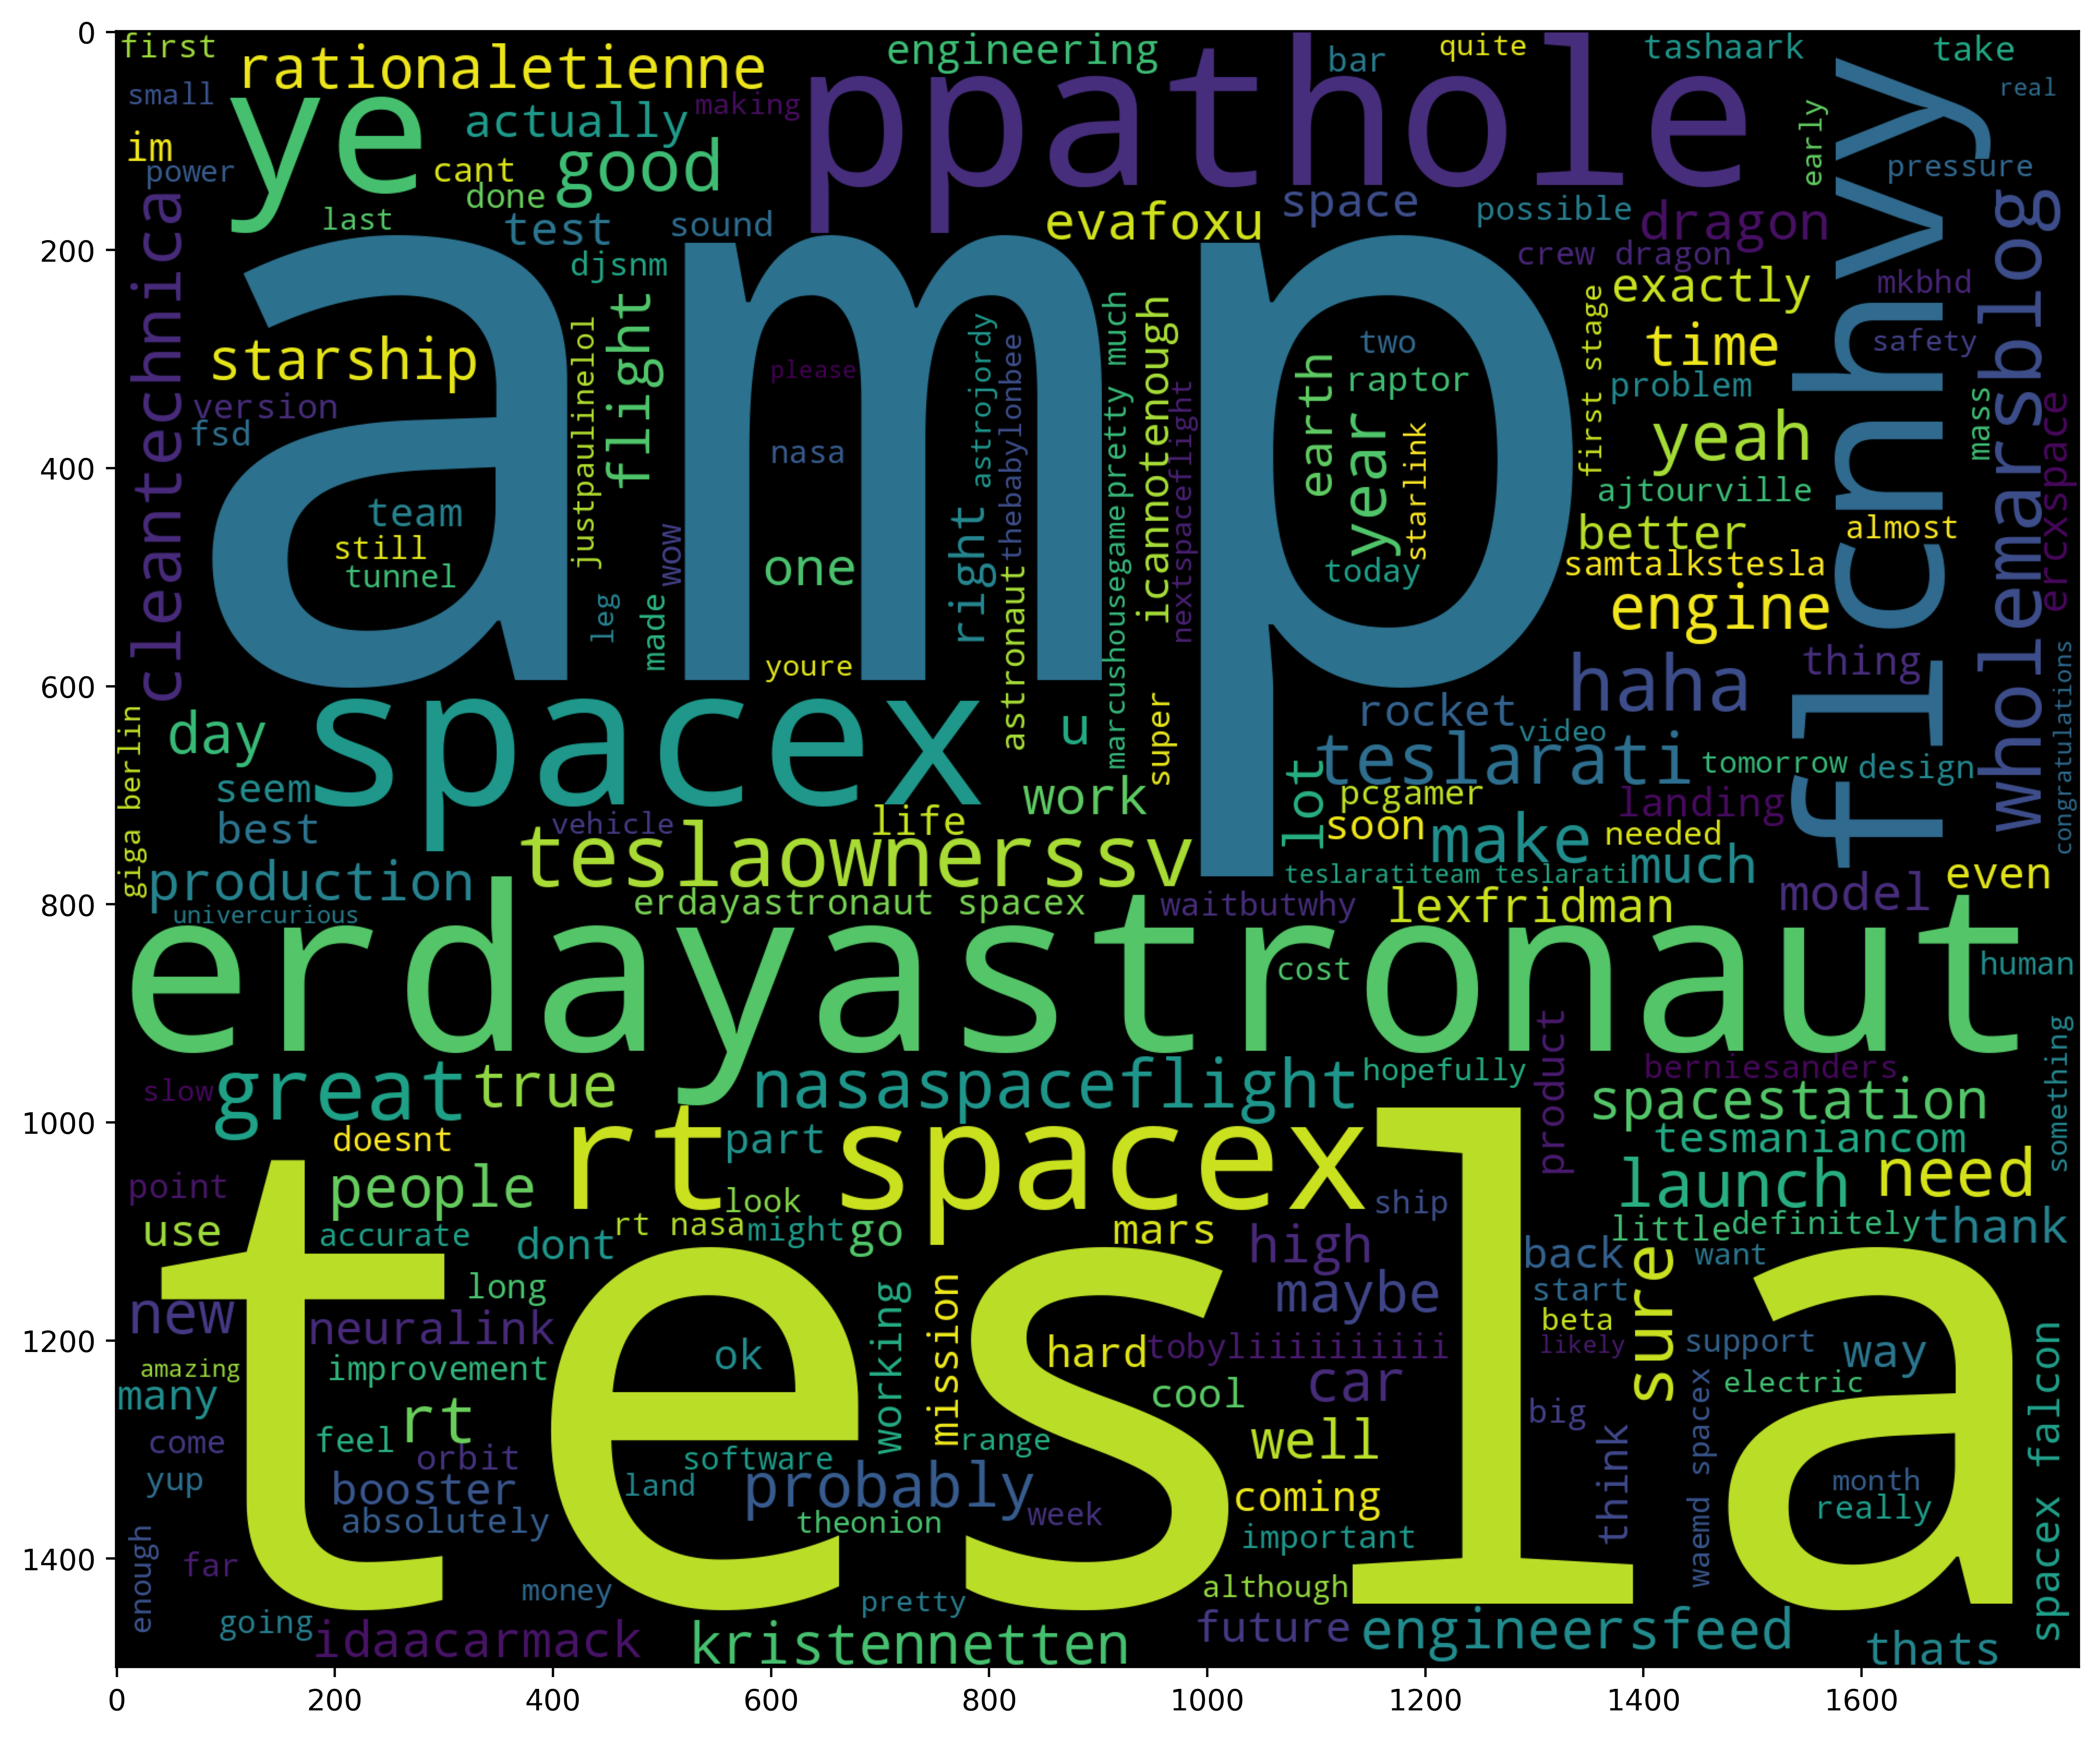

In [36]:
#wordcloud for entire corpus
from wordcloud import WordCloud
plt.figure(figsize=(12,12),dpi=500)
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500
                ).generate(string_Total)
plt.imshow(wordcloud_stw)

## Subjective and Polarity

In [38]:
from textblob import TextBlob

# Get The Subjectivity
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["Text"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

# Adding Subjectivity & Polarity
tweets[["subjectivity", "polarity"]] = tweets.apply(sentiment_analysis, axis=1)
tweets.head(11)

Text  subjectivity  polarity
0                                            im alien      0.750000 -0.250000
1   idaacarmack ray tracing cyberpunk hdr nextleve...      0.000000  0.000000
2                    joerogan spotify great interview      0.750000  0.800000
3                                 doge underestimated      0.000000  0.000000
4   teslacn congratulations tesla china amazing ex...      0.322222  0.200000
5                                   happy new year ox      0.727273  0.468182
6   frodo underdoge thought would fail httpstcozgx...      0.300000 -0.500000
7                      owensparks flcnhvy haha thanks      0.250000  0.200000
8   flcnhvy indeed tweets definitely represent rea...      0.500000  0.000000
9                         entertaining outcome likely      0.850000  0.250000
10                                  givedirectly sent      0.000000  0.000000

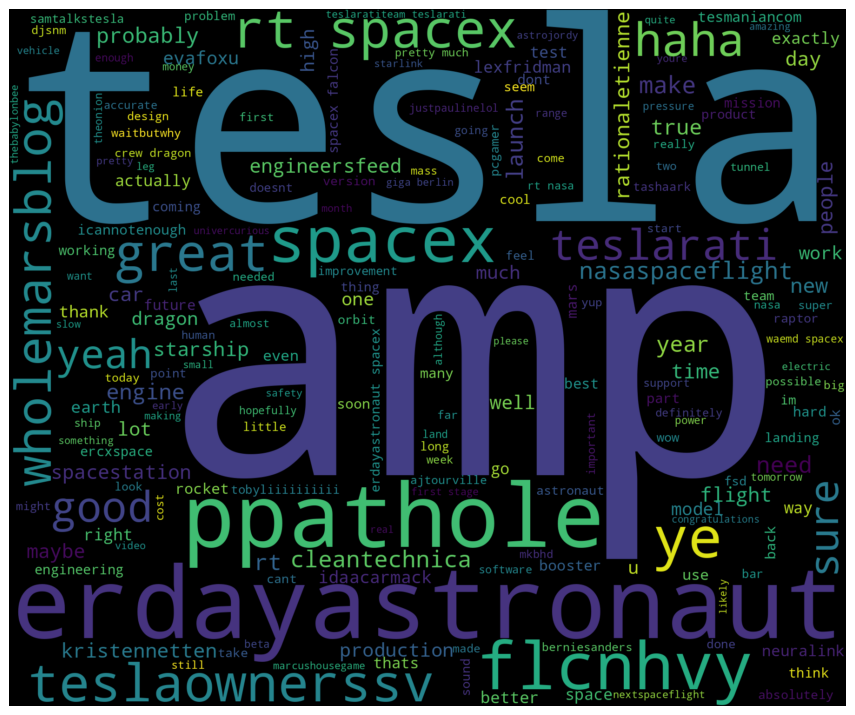

In [39]:
# Wordcloud
allwords = " ".join([twts for twts in tweets["Text"]])
wordCloud = WordCloud(width = 1800, height = 1500, random_state = 21).generate(allwords)
plt.figure(figsize=(12,12), dpi=90)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [43]:
# 1 way
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [44]:
# Compute The Negative, Neutral, Positive Analysis
def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

# Create a New Analysis Column
tweets["analysis"] = tweets["polarity"].apply(analysis)

In [45]:
positive_tweets = tweets[tweets['analysis'] == 'Positive']
negative_tweets = tweets[tweets['analysis'] == 'Negative']

print('positive tweets')
for i, row in positive_tweets[:5].iterrows():
    print(' -' + row['Text'])

print('negative tweets')
for i, row in negative_tweets[:5].iterrows():
    print(' -' + row['Text'])

positive tweets
 -joerogan spotify great interview
 -teslacn congratulations tesla china amazing execution last year next even
 -happy new year ox
 -owensparks flcnhvy haha thanks
 -entertaining outcome likely
negative tweets
 -im alien
 -frodo underdoge thought would fail httpstcozgxjfdzzrm
 -freewalletorg app sucks
 -rationaletienne adamklotz starlink staggeringly difficult technical amp economic endeavor however
 -rationaletienne adamklotz spacex needs pass deep chasm negative cash flow next year


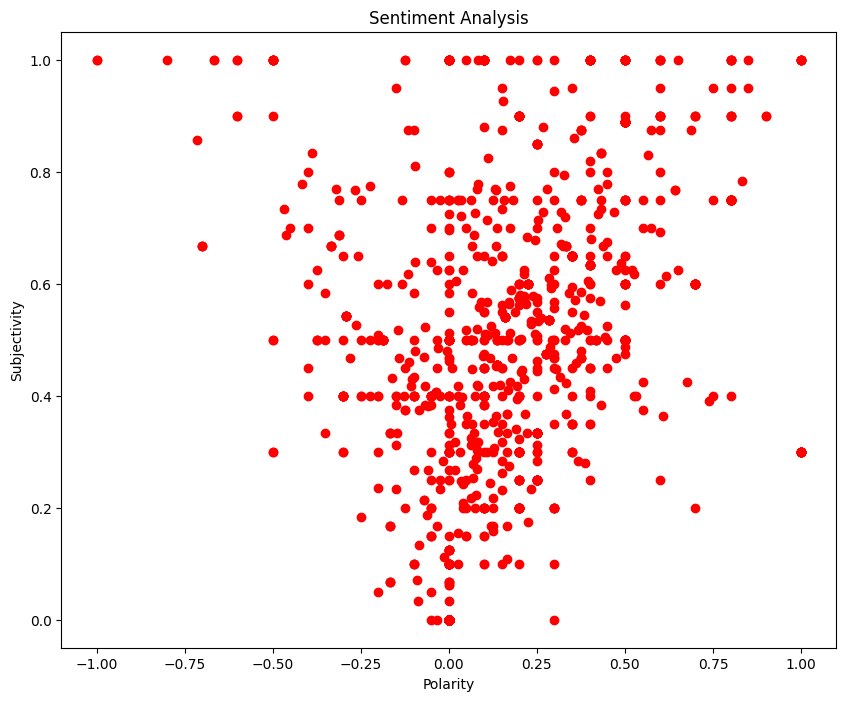

In [46]:
plt.figure(figsize=(10, 8))

for i in range(0, tweets.shape[0]):
    plt.scatter(tweets["polarity"][i], tweets["subjectivity"][i], color = "Red")

plt.title("Sentiment Analysis") # Add The Graph Title
plt.xlabel("Polarity") # Add The X-Label
plt.ylabel("Subjectivity") # Add The Y-Label
plt.show() # Showing The Graph

In [47]:
(len(positive_tweets) / len(negative_tweets))*100

422.11055276381904

## Apply Naive Bayes for classification

In [79]:
tweets.head()

Text  subjectivity  polarity  \
0                                           im alien      0.750000     -0.25   
1  idaacarmack ray tracing cyberpunk hdr nextleve...      0.000000      0.00   
2                   joerogan spotify great interview      0.750000      0.80   
3                                doge underestimated      0.000000      0.00   
4  teslacn congratulations tesla china amazing ex...      0.322222      0.20   

   analysis  
0  Negative  
1   Neutral  
2  Positive  
3   Neutral  
4  Positive

In [80]:
data = tweets.iloc[:,[0,-1]]
data

Text  analysis
0                                              im alien  Negative
1     idaacarmack ray tracing cyberpunk hdr nextleve...   Neutral
2                      joerogan spotify great interview  Positive
3                                   doge underestimated   Neutral
4     teslacn congratulations tesla china amazing ex...  Positive
...                                                 ...       ...
1994  flcnhvy true sounds surreal negative propagand...  Positive
1995  ppathole make sure read ur terms amp condition...  Positive
1996                  teslagong ppathole samwise gamgee   Neutral
1997                         ppathole altho dumb dumber  Negative
1998                             progress update august   Neutral

[1999 rows x 2 columns]

In [81]:
# Tokenization
def split_into_words(i):
    return (i.split(" "))

In [82]:
from sklearn.model_selection import train_test_split
tweets_train,tweets_test = train_test_split(data,test_size=0.3)

In [83]:
tweets_test

Text  analysis
1054  marcushousegame bocachicagal nasaspaceflight g...  Positive
1877  flcnhvy astrobehnken astrodoug spacex still lo...  Positive
1637  timothybuffett teslarati apart failing quarant...  Positive
1234  spacex marcushousegame really need better legs...  Positive
1603            tesmaniancom generally try best patents  Positive
...                                                 ...       ...
1665  space travel becomes common air travel future ...  Negative
1446            lengthy background neuralink waitbutwhy   Neutral
1648  trevormahlmann arstechnica legs longer legs mu...  Positive
1090      flight amp landing booster httpstcouotvmkgxqh   Neutral
1658  nasaspaceflight scrubbed day raptor turbopump ...   Neutral

[600 rows x 2 columns]

In [84]:
# Preparing tweets texts into word count matrix format
tweets_bow = CountVectorizer(analyzer=split_into_words).fit(data.Text)

In [85]:
# For all tweets
all_tweets_matrix = tweets_bow.transform(data.Text)
all_tweets_matrix.shape

(1999, 4483)

In [86]:
all_tweets_matrix

<1999x4483 sparse matrix of type '<class 'numpy.int64'>'
	with 13157 stored elements in Compressed Sparse Row format>

In [87]:
# For training messages
train_tweets_matrix = tweets_bow.transform(tweets_train.Text)
train_tweets_matrix.shape

(1399, 4483)

In [88]:
# For testing messages
test_tweets_matrix = tweets_bow.transform(tweets_test.Text)
test_tweets_matrix.shape

(600, 4483)

In [90]:
# Without TFIDF matrices
# Preparing a naive bayes model on training data set

from sklearn.naive_bayes import MultinomialNB as MB


# Multinomial Naive Bayes
classifier_mb = MB()
classifier_mb.fit(train_tweets_matrix,tweets_train.analysis)

train_pred_m = classifier_mb.predict(train_tweets_matrix)
accuracy_train_m = np.mean(train_pred_m==tweets_train.analysis)
test_pred_m = classifier_mb.predict(test_tweets_matrix)
accuracy_test_m = np.mean(test_pred_m==tweets_test.analysis)

In [91]:
accuracy_test_m

0.72

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer

# Learning Term weighting and normalizing on entire emails
tfidf_transformer = TfidfTransformer().fit(all_tweets_matrix)

# Preparing TFIDF for train emails
train_tfidf = tfidf_transformer.transform(train_tweets_matrix)

# Preparing TFIDF for test emails
test_tfidf = tfidf_transformer.transform(test_tweets_matrix)


In [94]:
# Preparing a naive bayes model on training data set

from sklearn.naive_bayes import MultinomialNB as MB


# Multinomial Naive Bayes
classifier_mb = MB()
classifier_mb.fit(train_tfidf,tweets_train.analysis)
train_pred_m = classifier_mb.predict(train_tfidf)
accuracy_train_m = np.mean(train_pred_m==tweets_train.analysis)

test_pred_m = classifier_mb.predict(test_tfidf)
accuracy_test_m = np.mean(test_pred_m==tweets_test.analysis)

In [95]:
accuracy_test_m

0.7183333333333334